In [36]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import time
import pickle as pk
from edo_fdm_model import fdm
import matplotlib.pyplot as plt

# Turn interactive plotting off
plt.ioff()

In [37]:
k = 0.01
t_lower = 0.0
t_upper = 10
phi = 0.2
ksi = 0.0
cb = 0.15
C_nmax = 0.55
mi_n = 0.2
lambd_bn = 0.1
y_n = 0.1

size_t = int(((t_upper - t_lower) / (k)))

lmb_var = 0.1

lmb_list = np.linspace(
    1.8 * (1 - lmb_var), 1.8 * (1 + lmb_var), num=size_t + 1, endpoint=True
)

print(
    "Steps in time = {:d}\n".format(
        size_t,
    )
)

t_np = np.linspace(t_lower, t_upper, num=size_t + 1, endpoint=True)

for i, lbm_nb in enumerate(lmb_list):

    struct_name = (
        "k--"
        + str(k)
        + "__phi--0.2__ksi--0.0__cb--0.15__Cn_max--0.55__lambd_nb--"
        + str(lbm_nb)
        + "__mi_n--0.2__lambd_bn--0.1__y_n--0.1__t_lower--"
        + str(t_lower)
        + "__t_upper--"
        + str(t_upper)
    )

    if i == 0:
        Cp_old, Cl_old = fdm(
            k,
            phi,
            ksi,
            cb,
            C_nmax,
            lbm_nb,
            mi_n,
            lambd_bn,
            y_n,
            t_lower,
            t_upper,
            plot=False,
        )

    else:
        Cp_new, Cl_new = fdm(
            k,
            phi,
            ksi,
            cb,
            C_nmax,
            lbm_nb,
            mi_n,
            lambd_bn,
            y_n,
            t_lower,
            t_upper,
            plot=False,
        )

        Cp_old = np.vstack((Cp_old.copy(), Cp_new))
        Cl_old = np.vstack((Cl_old.copy(), Cl_new))

    print(i + 1, "de", len(lmb_list))

Steps in time = 1000

1 de 1001
2 de 1001
3 de 1001
4 de 1001
5 de 1001
6 de 1001
7 de 1001
8 de 1001
9 de 1001
10 de 1001
11 de 1001
12 de 1001
13 de 1001
14 de 1001
15 de 1001
16 de 1001
17 de 1001
18 de 1001
19 de 1001
20 de 1001
21 de 1001
22 de 1001
23 de 1001
24 de 1001
25 de 1001
26 de 1001
27 de 1001
28 de 1001
29 de 1001
30 de 1001
31 de 1001
32 de 1001
33 de 1001
34 de 1001
35 de 1001
36 de 1001
37 de 1001
38 de 1001
39 de 1001
40 de 1001
41 de 1001
42 de 1001
43 de 1001
44 de 1001
45 de 1001
46 de 1001
47 de 1001
48 de 1001
49 de 1001
50 de 1001
51 de 1001
52 de 1001
53 de 1001
54 de 1001
55 de 1001
56 de 1001
57 de 1001
58 de 1001
59 de 1001
60 de 1001
61 de 1001
62 de 1001
63 de 1001
64 de 1001
65 de 1001
66 de 1001
67 de 1001
68 de 1001
69 de 1001
70 de 1001
71 de 1001
72 de 1001
73 de 1001
74 de 1001
75 de 1001
76 de 1001
77 de 1001
78 de 1001
79 de 1001
80 de 1001
81 de 1001
82 de 1001
83 de 1001
84 de 1001
85 de 1001
86 de 1001
87 de 1001
88 de 1001
89 de 1001
90 de 10

In [73]:
tt, ll = np.meshgrid(t_np, lmb_list)

data_input_np = np.array([Cl_old.flatten(), Cp_old.flatten()]).T

if torch.cuda.is_available():
    device = torch.device("cuda")
    t = (
        torch.tensor(tt, dtype=torch.float32, requires_grad=True)
        .reshape(-1, 1)
        .to(device)
    )
    lambd_nb = (
        torch.tensor(ll, dtype=torch.float32, requires_grad=True)
        .reshape(-1, 1)
        .to(device)
    )
    data_input = torch.tensor(data_input_np, dtype=torch.float32).to(device)

else:
    device = torch.device("cpu")
    t = torch.tensor(tt, dtype=torch.float32, requires_grad=True).reshape(-1, 1)
    lambd_nb = torch.tensor(ll, dtype=torch.float32, requires_grad=True).reshape(-1, 1)
    data_input = torch.tensor(data_input_np, dtype=torch.float32)

print(device)

cuda


In [74]:
activation_dict = {
    "Elu": nn.ELU,
    "LeakyReLU": nn.LeakyReLU,
    "Sigmoid": nn.Sigmoid,
    "Softplus": nn.Softplus,
    "Tanh": nn.Tanh,
    "Linear": nn.Linear,
    "ReLU": nn.ReLU,
    "RReLU": nn.RReLU,
    "SELU": nn.SELU,
    "CELU": nn.CELU,
    "GELU": nn.GELU,
    "SiLU": nn.SiLU,
    "GLU": nn.GLU,
}

In [75]:
arch_str = "Tanh--32__Tanh--32__Tanh--32__GELU--32"

In [76]:
def generate_model(arch_str):

    hidden_layers = arch_str.split("__")

    modules = []

    for params in hidden_layers:

        if len(params) != 0:
            activation, out_neurons = params.split("--")

            if len(modules) == 0:
                if activation == "Linear":
                    modules.append(activation_dict[activation](2, int(out_neurons)))

                else:
                    modules.append(nn.Linear(2, int(out_neurons)))
                    modules.append(activation_dict[activation]())

            else:
                if activation == "Linear":
                    modules.append(
                        activation_dict[activation](int(in_neurons), int(out_neurons))
                    )

                else:
                    modules.append(nn.Linear(int(in_neurons), int(out_neurons)))
                    modules.append(activation_dict[activation]())

            in_neurons = out_neurons

    modules.append(nn.Linear(int(in_neurons), 2))

    return nn.Sequential(*modules)

In [77]:
model = generate_model(arch_str).to(device)

print(model)

Sequential(
  (0): Linear(in_features=2, out_features=32, bias=True)
  (1): Tanh()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): Tanh()
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): Tanh()
  (6): Linear(in_features=32, out_features=32, bias=True)
  (7): GELU(approximate='none')
  (8): Linear(in_features=32, out_features=2, bias=True)
)


In [78]:
def initial_condition(t):
    Cl = torch.zeros_like(t)
    Cp = torch.zeros_like(t) + 0.2
    return torch.cat([Cl, Cp], dim=1)

In [79]:
def pde(t, lambd_nb, model):

    mesh = torch.cat([t, lambd_nb], dim=1)

    Cl, Cp = model(mesh).split(1, dim=1)

    # Calculando Cp

    dCp_dt = torch.autograd.grad(
        Cp,
        t,
        grad_outputs=torch.ones_like(Cp),
        create_graph=True,
        retain_graph=True,
    )[0]

    Cp_eq = (cb - lambd_nb * Cl) * Cp * phi - dCp_dt

    # Calculando Cl

    dCl_dt = torch.autograd.grad(
        Cl,
        t,
        grad_outputs=torch.ones_like(Cl),
        create_graph=True,
        retain_graph=True,
    )[0]

    Cl_eq = (y_n * Cp * (C_nmax - 1) - (lambd_bn * Cp + mi_n)) * Cl * phi - dCl_dt

    del dCl_dt
    del dCp_dt

    torch.cuda.empty_cache()

    return torch.cat([Cl_eq, Cp_eq], dim=1)

In [80]:
loss_fn = nn.MSELoss()  # binary cross entropy
optimizer = optim.Adam(model.parameters(), lr=0.001)
decay_rate = 0.99

lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decay_rate)

n_epochs = 500
batch_size = 100000
C_pde_loss_it = torch.zeros(n_epochs).to(device)
C_data_loss_it = torch.zeros(n_epochs).to(device)
C_initial_loss_it = torch.zeros(n_epochs).to(device)
C_initial = initial_condition(t).to(device)

for epoch in range(n_epochs):
    for i in range(0, len(t), batch_size):

        t_initial = torch.zeros_like(t[i : i + batch_size])

        mesh = torch.cat([t_initial, lambd_nb[i : i + batch_size]], dim=1)
        C_initial_pred = model(mesh)

        loss_initial = loss_fn(C_initial[i : i + batch_size], C_initial_pred)

        mesh = torch.cat([t[i : i + batch_size], lambd_nb[i : i + batch_size]], dim=1)
        C_pred = model(mesh)

        loss_pde = loss_fn(
            pde(t[i : i + batch_size], lambd_nb[i : i + batch_size], model),
            torch.cat([t_initial, t_initial], dim=1),
        )

        loss_data = loss_fn(C_pred, data_input[i : i + batch_size])

        loss = 10*loss_initial + loss_pde + 10*loss_data
        # loss = loss_initial + loss_data

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # lr_scheduler.step()

    C_pde_loss_it[epoch] = loss_pde.item()
    C_initial_loss_it[epoch] = loss_initial.item()
    C_data_loss_it[epoch] = loss_data.item()

    if epoch % 100 == 0:
        print(f"Finished epoch {epoch}, latest loss {loss}")

Finished epoch 0, latest loss 0.24518337845802307
Finished epoch 100, latest loss 0.008473644964396954
Finished epoch 200, latest loss 0.0027834372594952583
Finished epoch 300, latest loss 0.0023128874599933624
Finished epoch 400, latest loss 0.0015913511160761118


In [81]:
pinn_file = "epochs_{}__batch_{}__arch_".format(n_epochs, batch_size) + arch_str

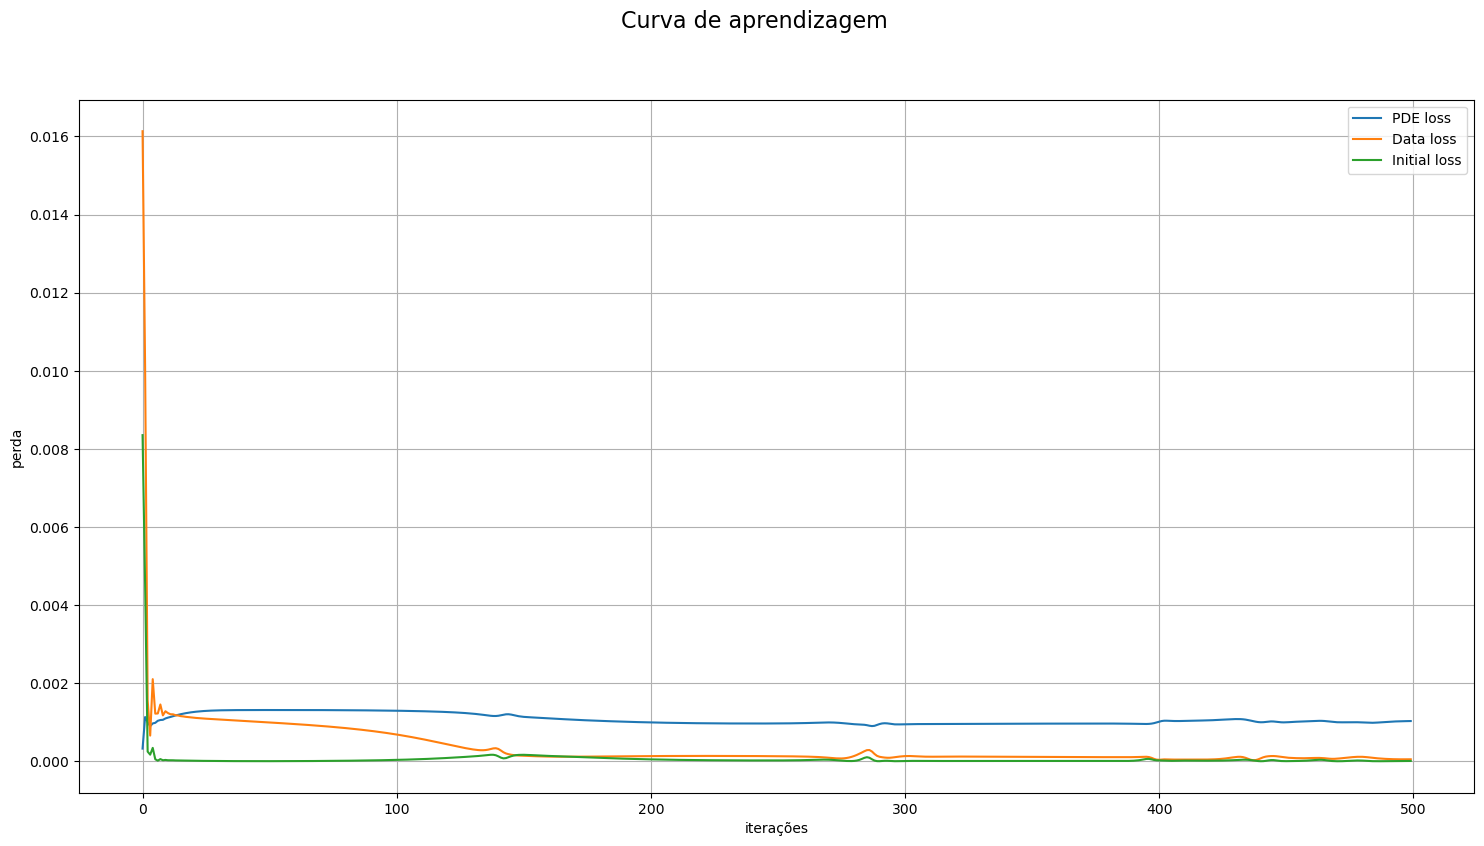

In [82]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[18, 9])

fig.suptitle("Curva de aprendizagem", fontsize=16)

# Plotango 3D
ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel("iterações")
ax.set_ylabel("perda")
ax.plot(
    range(len(C_pde_loss_it.cpu().numpy())),
    C_pde_loss_it.cpu().numpy(),
    label="PDE loss",
)
ax.plot(
    range(len(C_data_loss_it.cpu().numpy())),
    C_data_loss_it.cpu().numpy(),
    label="Data loss",
)
ax.plot(
    range(len(C_initial_loss_it.cpu().numpy())),
    C_initial_loss_it.cpu().numpy(),
    label="Initial loss",
)
# ax.set_yscale("log")
ax.grid()
ax.legend()

plt.savefig("learning_curves/" + pinn_file + ".png")
plt.show()

In [83]:
model_cpu = model.to("cpu")

speed_up = []

mesh = torch.cat([t, lambd_nb], dim=1).to("cpu")

for i in range(10):

    fdm_start = time.time()

    for lbm_nb in lmb_list:

        struct_name = (
            "k--"
            + str(k)
            + "__phi--0.2__ksi--0.0__cb--0.15__Cn_max--0.55__lambd_nb--"
            + str(lbm_nb)
            + "__mi_n--0.2__lambd_bn--0.1__y_n--0.1__t_lower--"
            + str(t_lower)
            + "__t_upper--"
            + str(t_upper)
        )

        _, _ = fdm(
            k,
            phi,
            ksi,
            cb,
            C_nmax,
            lbm_nb,
            mi_n,
            lambd_bn,
            y_n,
            t_lower,
            t_upper,
        )

    fdm_end = time.time()

    pinn_start = time.time()

    with torch.no_grad():
        Cl_pinn, Cp_pinn = model_cpu(mesh).split(1, dim=1)

    pinn_end = time.time()

    fdm_time = fdm_end - fdm_start

    pinn_time = pinn_end - pinn_start

    speed_up.append(fdm_time / pinn_time)

In [84]:
mean_speed_up = np.mean(speed_up)
std_speed_up = np.std(speed_up)

rmse = np.mean(
    [
        ((Cl_p[0] - Cl_f) ** 2 + (Cp_p[0] - Cp_f) ** 2) ** 0.5
        for Cl_p, Cp_p, Cl_f, Cp_f in zip(
            Cl_pinn, Cp_pinn, Cl_old.flatten(), Cp_old.flatten()
        )
    ]
)

max_ae = np.max(
    [
        [((Cl_p[0] - Cl_f) ** 2) ** 0.5, ((Cp_p[0] - Cp_f) ** 2) ** 0.5]
        for Cl_p, Cp_p, Cl_f, Cp_f in zip(
            Cl_pinn, Cp_pinn, Cl_old.flatten(), Cp_old.flatten()
        )
    ]
)

In [85]:
output = {
    "rmse": rmse,
    "max_ae": max_ae,
    "mean_speed_up": mean_speed_up,
    "std_speed_up": std_speed_up,
    "Cl_pinn": Cl_pinn,
    "Cp_pinn": Cp_pinn,
}

In [86]:
print("Erro absoluto médio", rmse)
print("Erro absoluto máximo", max_ae)
print("Speed Up: {} +/-{}".format(mean_speed_up, std_speed_up))

Erro absoluto médio 0.009715152
Erro absoluto máximo 0.019968718
Speed Up: 2.29474025414967 +/-0.06977044652212719


In [87]:
with open("edo_pinn_sim/" + pinn_file + ".pkl", "wb") as f:
    pk.dump(output, f)

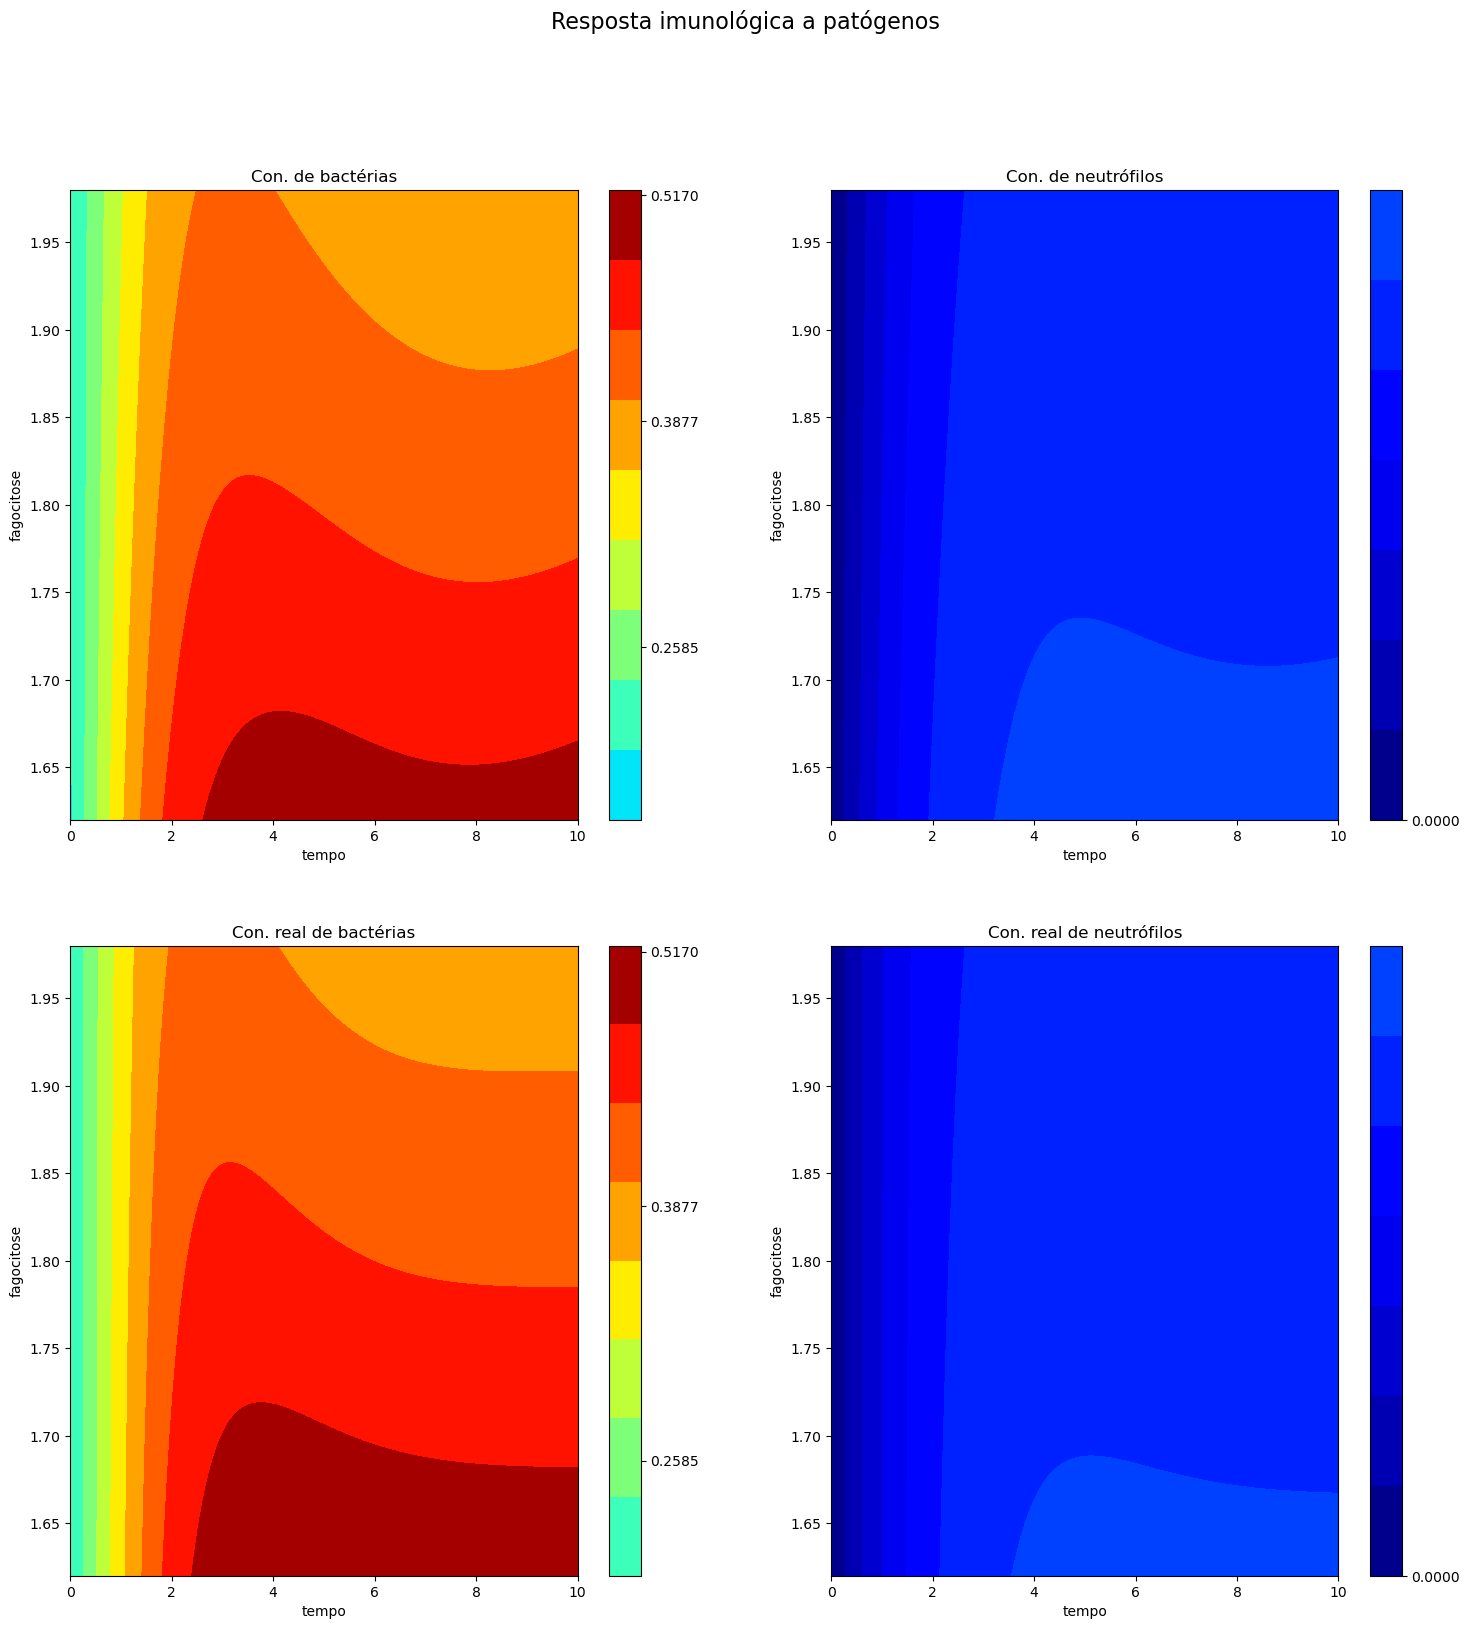

In [88]:
Cl_pinn_np = Cl_pinn.detach().numpy().reshape(size_t + 1, size_t + 1)
Cp_pinn_np = Cp_pinn.detach().numpy().reshape(size_t + 1, size_t + 1)

fig = plt.figure(figsize=[18, 18])

fig.suptitle("Resposta imunológica a patógenos", fontsize=16)

vmin = 0
vmax = np.max(
    [
        np.max(Cp_pinn.cpu().numpy()),
        np.max(Cl_pinn.cpu().numpy()),
        np.max(Cp_old),
        np.max(Cl_old),
    ]
)

# Plotango 3D
ax = fig.add_subplot(2, 2, 1)

contour = ax.contourf(
    tt,
    ll,
    Cp_pinn_np,
    cmap="jet",
    vmin=vmin,
    vmax=vmax,
)
ax.set_title("Con. de bactérias")
ax.set_xlabel("tempo")
ax.set_ylabel("fagocitose")
colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

# Plotando 2D

ax = fig.add_subplot(2, 2, 2)

contour = ax.contourf(
    tt,
    ll,
    Cl_pinn_np,
    cmap="jet",
    vmin=vmin,
    vmax=vmax,
)
ax.set_title("Con. de neutrófilos")
ax.set_xlabel("tempo")
ax.set_ylabel("fagocitose")

colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

# Plotango 3D
ax = fig.add_subplot(2, 2, 3)

contour = ax.contourf(
    tt,
    ll,
    Cp_old.reshape(size_t + 1, size_t + 1),
    cmap="jet",
    vmin=vmin,
    vmax=vmax,
)
ax.set_title("Con. real de bactérias")
ax.set_xlabel("tempo")
ax.set_ylabel("fagocitose")
colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

# Plotando 2D

ax = fig.add_subplot(2, 2, 4)

contour = ax.contourf(
    tt,
    ll,
    Cl_old.reshape(size_t + 1, size_t + 1),
    cmap="jet",
    vmin=vmin,
    vmax=vmax,
)
ax.set_title("Con. real de neutrófilos")
ax.set_xlabel("tempo")
ax.set_ylabel("fagocitose")

colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

plt.show()

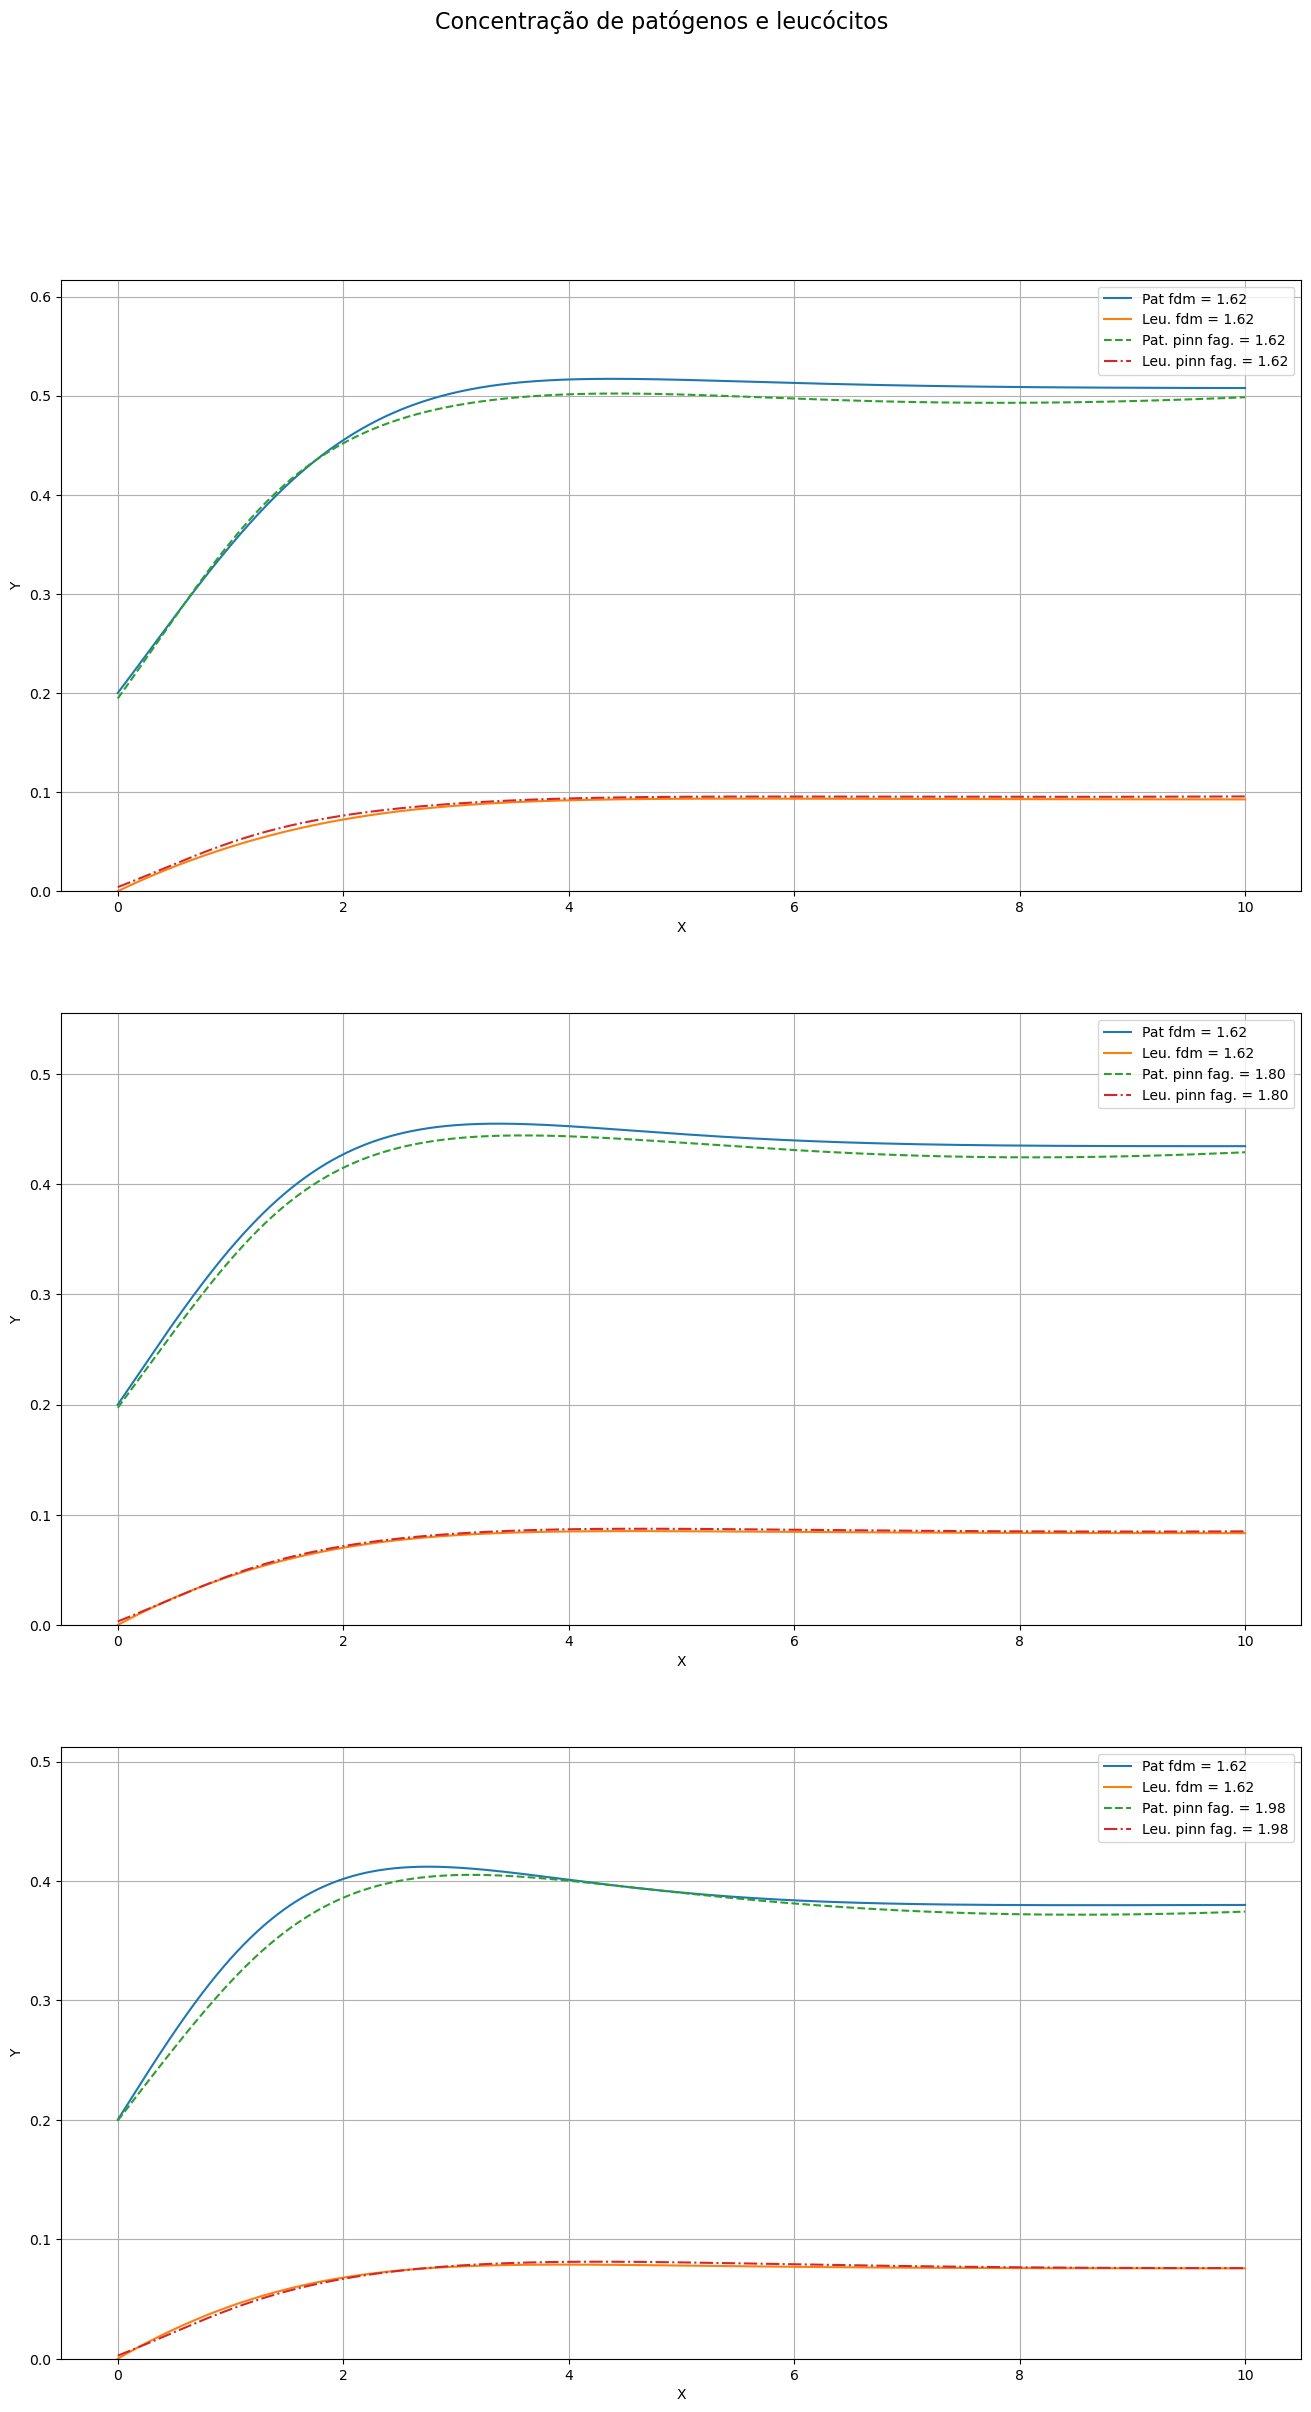

In [89]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[16, 27])

fig.suptitle("Concentração de patógenos e leucócitos", fontsize=16)


vmin = 0

cp_real_1 = Cp_old[0, :]
cl_real_1 = Cl_old[0, :]
cp_pinn_1 = Cp_pinn_np[0, :]
cl_pinn_1 = Cl_pinn_np[0, :]
fag_1 = lambd_nb[0 * (size_t + 1)].cpu().detach().numpy()[0]

cp_real_2 = Cp_old[500, :]
cl_real_2 = Cl_old[500, :]
cp_pinn_2 = Cp_pinn_np[500, :]
cl_pinn_2 = Cl_pinn_np[500, :]
fag_2 = lambd_nb[500 * (size_t + 1)].cpu().detach().numpy()[0]

cp_real_3 = Cp_old[1000, :]
cl_real_3 = Cl_old[1000, :]
cp_pinn_3 = Cp_pinn_np[1000, :]
cl_pinn_3 = Cl_pinn_np[1000, :]
fag_3 = lambd_nb[1000 * (size_t + 1)].cpu().detach().numpy()[0]

# Plotango 3D
ax = fig.add_subplot(3, 1, 1)

ax.plot(t_np, cp_real_1, label="Pat fdm = {:.2f}".format(fag_1))
ax.plot(t_np, cl_real_1, label="Leu. fdm = {:.2f}".format(fag_1))
ax.plot(t_np, cp_pinn_1, "--", label="Pat. pinn fag. = {:.2f}".format(fag_1))
ax.plot(t_np, cl_pinn_1, "-.", label="Leu. pinn fag. = {:.2f}".format(fag_1))
ax.set_xlabel("X")
ax.set_ylabel("Y")

vmax = np.max(
    [
        np.max(cp_real_1),
        np.max(cl_real_1),
        np.max(cp_pinn_1),
        np.max(cl_pinn_1),
    ]
)
ax.set_ylim(vmin, vmax + 0.1)
ax.legend()
ax.grid()

ax = fig.add_subplot(3, 1, 2)

ax.plot(t_np, cp_real_2, label="Pat fdm = {:.2f}".format(fag_1))
ax.plot(t_np, cl_real_2, label="Leu. fdm = {:.2f}".format(fag_1))
ax.plot(t_np, cp_pinn_2, "--", label="Pat. pinn fag. = {:.2f}".format(fag_2))
ax.plot(t_np, cl_pinn_2, "-.", label="Leu. pinn fag. = {:.2f}".format(fag_2))
ax.set_xlabel("X")
ax.set_ylabel("Y")
vmax = np.max(
    [
        np.max(cp_real_2),
        np.max(cl_real_2),
        np.max(cp_pinn_2),
        np.max(cl_pinn_2),
    ]
)
ax.set_ylim(vmin, vmax + 0.1)
ax.legend()
ax.grid()

ax = fig.add_subplot(3, 1, 3)

ax.plot(t_np, cp_real_3, label="Pat fdm = {:.2f}".format(fag_1))
ax.plot(t_np, cl_real_3, label="Leu. fdm = {:.2f}".format(fag_1))
ax.plot(t_np, cp_pinn_3, "--", label="Pat. pinn fag. = {:.2f}".format(fag_3))
ax.plot(t_np, cl_pinn_3, "-.", label="Leu. pinn fag. = {:.2f}".format(fag_3))
ax.set_xlabel("X")
ax.set_ylabel("Y")
vmax = np.max(
    [
        np.max(cp_real_3),
        np.max(cl_real_3),
        np.max(cp_pinn_3),
        np.max(cl_pinn_3),
    ]
)
ax.set_ylim(vmin, vmax + 0.1)
ax.legend()
ax.grid()

plt.show()